In [50]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import datasets
import pandas as pd
import numpy as np
from torchvision.transforms import ToTensor

In [51]:
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


In [52]:
training_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [53]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [54]:
from sklearn.model_selection import train_test_split

test_data, val_data = train_test_split(test_data, test_size=0.1, random_state=42)

In [55]:
#val_data

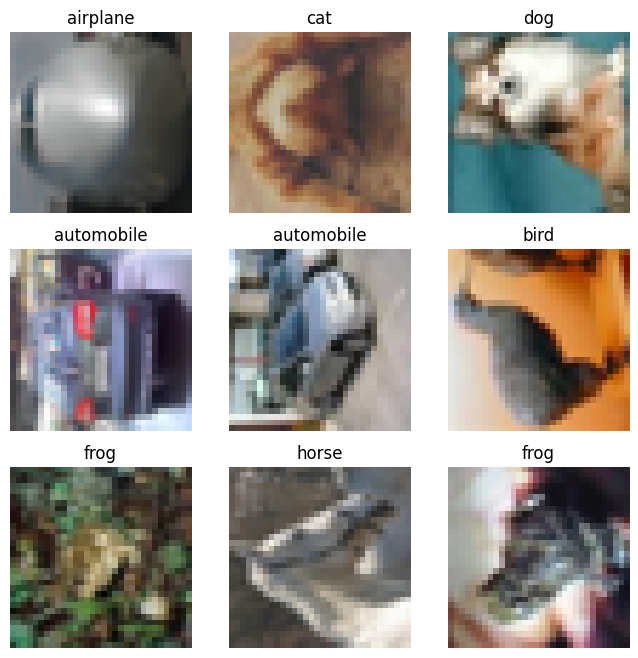

In [56]:
labels_map = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.T.squeeze())
plt.show()

In [57]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)

In [58]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [59]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.block1 = nn.Sequential(
        nn.Conv2d(3, 32, 3, 1),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.Conv2d(32, 64, 3, 1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2),
        nn.Dropout(0.25),
        )
    self.block2 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(12544, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(128,10),
        nn.BatchNorm1d(10)
        )
  def forward(self, x):
    x = self.block1(x)
    return self.block2(x)

In [60]:
model = Net()
model.to(device)
print(model)

Net(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (block2): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12544, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=128, out_features=10, bias=True)
    (6): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


In [61]:
import torch.optim as optim

In [62]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: Net(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (block2): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12544, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=128, out_features=10, bias=True)
    (6): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


Layer: block1.0.weight | Size:

In [63]:
learning_rate=1e-4

In [64]:
running_losses=[]
val_losses=[]

In [66]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
num_epochs = 10  # You can adjust the number of epochs as needed

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.type(torch.float).to(device),labels.to(device)

        #inputs = inputs.view(64, 3, 28, 28)  # Reshaping to (batch_size, channels, height, width)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print the average loss for this epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {running_loss / len(train_dataloader)}")

    # Evaluation on the validation dataset
    model.eval()
    correct = 0
    val_loss=0
    total = 0
    with torch.no_grad():
        for data in val_dataloader:
            inputs, labels = data
            inputs, labels = inputs.type(torch.float).to(device),labels.to(device)
            outputs = model(inputs)
            val_loss+= loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy on validation data: {(correct / total) * 100}%")
    
    running_losses.append(running_loss)
    val_losses.append(val_loss)

print("Training finished")

Epoch [1/10] Loss: 1.3293838569575258
Accuracy on validation data: 65.5%
Epoch [2/10] Loss: 1.2170480206189558
Accuracy on validation data: 68.10000000000001%
Epoch [3/10] Loss: 1.1414604268567947
Accuracy on validation data: 67.7%
Epoch [4/10] Loss: 1.0852037152975722
Accuracy on validation data: 69.6%
Epoch [5/10] Loss: 1.0338634562766766
Accuracy on validation data: 68.8%
Epoch [6/10] Loss: 0.9921729560093502
Accuracy on validation data: 69.5%
Epoch [7/10] Loss: 0.9561702549609992
Accuracy on validation data: 68.8%
Epoch [8/10] Loss: 0.9216782808151391
Accuracy on validation data: 69.1%
Epoch [9/10] Loss: 0.8926701619649482
Accuracy on validation data: 70.1%
Epoch [10/10] Loss: 0.8612371177777
Accuracy on validation data: 69.89999999999999%
Training finished


In [67]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data
        inputs, labels = inputs.type(torch.float).to(device),labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Accuracy on test data: {(correct / total) * 100}%")

Accuracy on test data: 70.87777777777777%


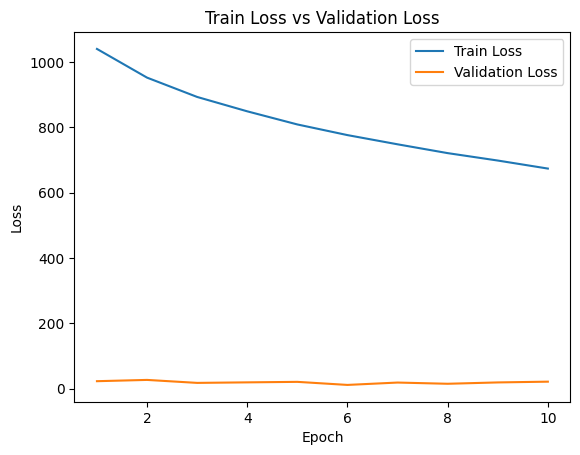

In [68]:
plt.figure()
plt.plot(range(1, num_epochs+1), running_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train Loss vs Validation Loss")
plt.legend()
plt.show()